<a href="https://colab.research.google.com/github/youhs1125/Kaggle/blob/main/Playground_Series_Season3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
from google.colab import drive
drive.mount('/content/drive')

key_path = '/content/drive/MyDrive/Kaggle/Kaggle_key/kaggle.json'

with open(key_path) as f:
  api = json.load(f)
  os.environ["KAGGLE_USERNAME"] = api['username']
  os.environ["KAGGLE_KEY"] = api['key']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!kaggle competitions download -c playground-series-s3e1
!unzip -qq "/content/playground-series-s3e1.zip"

  0% 0.00/2.33M [00:00<?, ?B/s]
100% 2.33M/2.33M [00:00<00:00, 132MB/s]


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.utils.data as td
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  loss_track = np.array([])
  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    pred = model(X)
    loss = loss_fn(pred,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch%100 == 0:
      loss, current = loss.item(),batch*len(X)
      loss_track = np.append(loss_track,np.array(loss))
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    
  return np.mean(loss_track)

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0,0

  with torch.no_grad():
    for X, y in dataloader:
      X,y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f}\n")
  return test_loss

cuda


In [ ]:
train = pd.read_csv("train.csv")
print(train.columns) 
train_y = torch.FloatTensor((train[["MedHouseVal"]].copy()).to_numpy())

train_y = np.log(train_y)

train_X = torch.FloatTensor((train.drop(['MedHouseVal'],axis=1)).to_numpy())
print(train_X.shape)

dataset = td.TensorDataset(train_X, train_y)

train_size = int(train_X.shape[0] * 0.8)
validation_size =  train_X.shape[0] - train_size

train_data, validation_data = td.random_split(dataset,[train_size, validation_size])

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size = 32, shuffle=False)

Index(['id', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')
torch.Size([37137, 9])


In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.linear_relu_stack = nn.Sequential(
        nn.BatchNorm1d(train_X.shape[1]),
        nn.Linear(train_X.shape[1],256),
        nn.BatchNorm1d(256),
        # nn.ReLU(),
        nn.ELU(),
        nn.Dropout(0.4),
        nn.Linear(256,128),
        nn.BatchNorm1d(128),
        # nn.ReLU(),
        nn.ELU(),
        nn.Dropout(0.3),
        nn.Linear(128,1),
    )
  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

model = NeuralNetwork().to(device)

In [ ]:
epochs = 40
loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss = np.empty
val_loss = []
for t in range(epochs):
  print(f"Epoch {t+1}\n----------------")
  loss_train = train_loop(train_dataloader, model, loss_fn, optimizer)
  train_loss = np.append(train_loss,loss_train)
  loss_test = test_loop(validation_dataloader, model, loss_fn)
  val_loss.append(loss_test)
print("Done!")

Epoch 1
----------------
loss: 1.193526 [    0/29709]
loss: 0.239391 [ 3200/29709]
loss: 0.190503 [ 6400/29709]
loss: 0.214175 [ 9600/29709]
loss: 0.171645 [12800/29709]
loss: 0.180985 [16000/29709]
loss: 0.113652 [19200/29709]
loss: 0.122266 [22400/29709]
loss: 0.097018 [25600/29709]
loss: 0.106102 [28800/29709]
Avg loss: 0.136576

Epoch 2
----------------
loss: 0.172951 [    0/29709]
loss: 0.102653 [ 3200/29709]
loss: 0.056527 [ 6400/29709]
loss: 0.086518 [ 9600/29709]
loss: 0.070877 [12800/29709]
loss: 0.114061 [16000/29709]
loss: 0.125748 [19200/29709]
loss: 0.132593 [22400/29709]
loss: 0.134635 [25600/29709]
loss: 0.188060 [28800/29709]
Avg loss: 0.124301

Epoch 3
----------------
loss: 0.092866 [    0/29709]
loss: 0.104348 [ 3200/29709]
loss: 0.172320 [ 6400/29709]
loss: 0.059046 [ 9600/29709]
loss: 0.087178 [12800/29709]
loss: 0.149884 [16000/29709]
loss: 0.125569 [19200/29709]
loss: 0.088192 [22400/29709]
loss: 0.090841 [25600/29709]
loss: 0.104792 [28800/29709]
Avg loss: 0.121

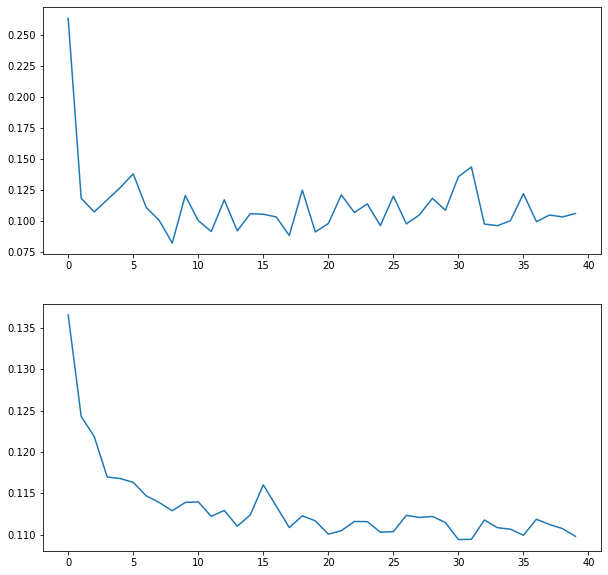

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(10,10))
axes[0].plot(train_loss[1:])
axes[1].plot(val_loss)

In [ ]:
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")
print(sub)

test = torch.FloatTensor(test.to_numpy()).to(device)

          id  MedHouseVal
0      37137     2.079751
1      37138     2.079751
2      37139     2.079751
3      37140     2.079751
4      37141     2.079751
...      ...          ...
24754  61891     2.079751
24755  61892     2.079751
24756  61893     2.079751
24757  61894     2.079751
24758  61895     2.079751

[24759 rows x 2 columns]


In [ ]:
result = model(test).detach().cpu()
result = result.flatten().numpy()
result = np.exp(result)
print(result.shape)
sub['MedHouseVal'] = result
print(sub)

(24759,)
          id  MedHouseVal
0      37137     0.518739
1      37138     1.024979
2      37139     3.485368
3      37140     3.143842
4      37141     2.074408
...      ...          ...
24754  61891     1.758993
24755  61892     1.626502
24756  61893     1.257812
24757  61894     3.705086
24758  61895     3.287060

[24759 rows x 2 columns]


In [ ]:
sub.to_csv("predict.csv",index=False)

In [ ]:
!kaggle competitions submit -c playground-series-s3e1 -f predict.csv -m "AUTO_SUBMIT"

100% 384k/384k [00:03<00:00, 103kB/s]
Successfully submitted to Playground Series Season 3, Episode 1